<a href="https://colab.research.google.com/github/Andiko-K/SkinColorDetection/blob/main/transfer-learning/UtkFace_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Dataset

In [ ]:
!gdown --id 1RO6yAXrIX2Ongvg4XbjAvuMx16GZ_g8f
!gdown --id 1IxAYnDlYs4pByNEeMaKcfwlcZ5wAoGbg
!gdown --id 1phARNDQ-giRJNGtQMHRnVNugfiy1dfzu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1RO6yAXrIX2Ongvg4XbjAvuMx16GZ_g8f
From (redirected): https://drive.google.com/uc?id=1RO6yAXrIX2Ongvg4XbjAvuMx16GZ_g8f&confirm=t&uuid=bb353bcc-3090-46b8-8c47-ae60d7b983bd
To: /content/utkface.zip
100% 51.4M/51.4M [00:00<00:00, 110MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IxAYnDlYs4pByNEeMaKcfwlcZ5wAoGbg
To: /content/color_swatches.npy
100% 248/248 [00:00<00:00, 643kB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecate

In [ ]:
import zipfile

local_file = 'utkface.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('utkface/')
zip_ref.close()

In [ ]:
local_file = 'model.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('./')
zip_ref.close()

# Uploading Model

In [ ]:
import os
from google.colab import files

def upload_model():
    uploaded = files.upload()
    os.makedirs('model', exist_ok=True)
    for model in uploaded.keys():
        os.rename(model, os.path.join('model', model))

upload_model()

Saving mobilev3scrop.h5 to mobilev3scrop.h5


# Testing

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# Unsupervised Learning

In [ ]:
color_swatches = np.load('color_swatches.npy')

def load_image(image_path, target_size):
    img = load_img(image_path, target_size = target_size)
    img_array = img_to_array(img)
    return img_array/255

def ZNorm(comp, threshold = 3):
    comp = tf.reshape(comp, (-1,3))
    z_score = (comp - tf.reduce_mean(comp, axis=0)) / tf.math.reduce_std(comp, axis=0)
    z_score = tf.abs(z_score)
    outliers = tf.reduce_any(z_score > threshold, axis=1)
    comp_cleaned = tf.boolean_mask(comp, ~outliers, axis=0)
    return comp_cleaned

def center_c(comp_cleaned, random_state = 22):
    centroid = tf.math.reduce_mean(comp_cleaned, axis = 0)
    centroid = tf.reshape(centroid, (1, 1, 3))
    return centroid

def closest_distance(centroid, color_swatches=color_swatches):
  color_swatches = color_swatches/255
  distances = (color_swatches-centroid)[0]
  distances_mse = tf.math.reduce_sum(tf.math.square(distances), axis = 1)

  distances_mse = tf.math.sqrt(distances_mse)
  label = tf.argmin(distances_mse)
  label = label.numpy()

  return label

def get_image(image_path, target_size, color_swatches=color_swatches):
  image = load_image(image_path, target_size)
  norm_image = ZNorm(image)
  centroid = center_c(norm_image)
  label = closest_distance(centroid)

  return image, label

def viz_utils(path_list, target_size):
    n = len(path_list)
    fig, ax = plt.subplots(1, n, figsize = (n*4, 4))
    for i, path_ in enumerate(path_list):
        img, prediction = get_image(path_, target_size)
        ax[i].imshow(img)
        ax[i].set_title(f'Tone {prediction+1}')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.tight_layout()
    plt.show()

def viz_swatches(color_swatches = color_swatches):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    color_index = 0

    for row in axes:
        for ax in row:
            if color_index < len(color_swatches):
                color = color_swatches[color_index] / 255.0
                ax.set_facecolor(color)
                ax.set_xticks([])
                ax.set_yticks([])
                color_index += 1
            else:
                ax.set_visible(False)

    plt.tight_layout()
    plt.show()

def predict_batch(path_list, target_size, num = 100):
  list_prediction = []
  images = random.sample(path_list, num)

  for path_ in images:
    list_prediction.append(get_image(path_, target_size)[1]+1)
  print('\n\n')
  plt.figure(figsize = (20,4))
  plt.hist(list_prediction)
  plt.title(f'SkinTone Prediction of  {num} data')
  plt.xticks(range(1, 11))
  plt.show()


def random_viz(path, target_size, num = 100):
    images = [os.path.join(path, i) for i in os.listdir(path) if not os.path.isdir(i)]
    image = random.sample(images, 5)
    viz_utils(image, target_size)
    predict_batch(images, target_size)

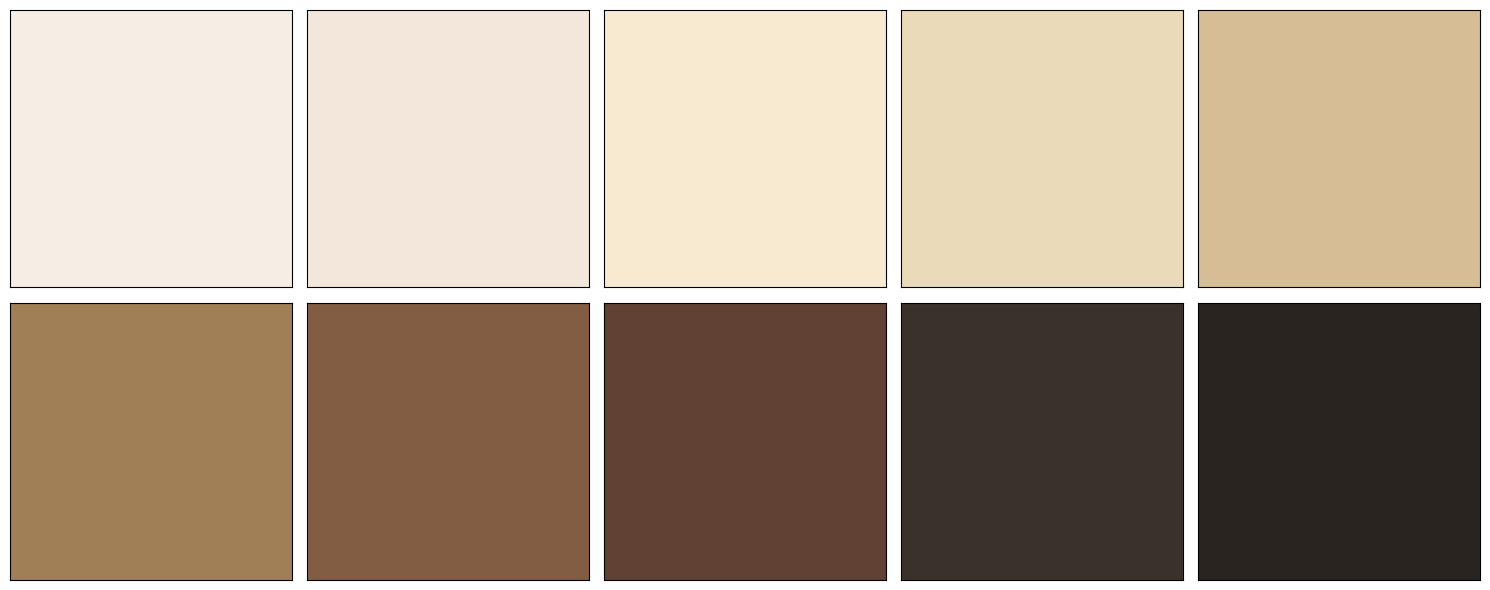

In [ ]:
viz_swatches()

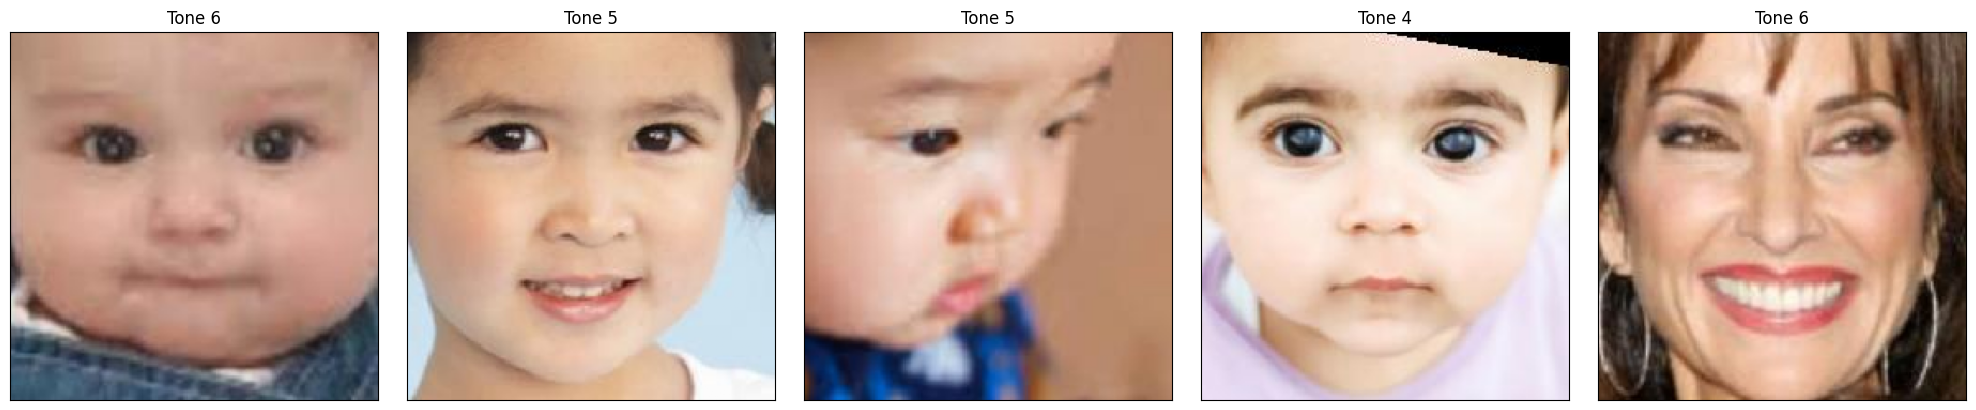

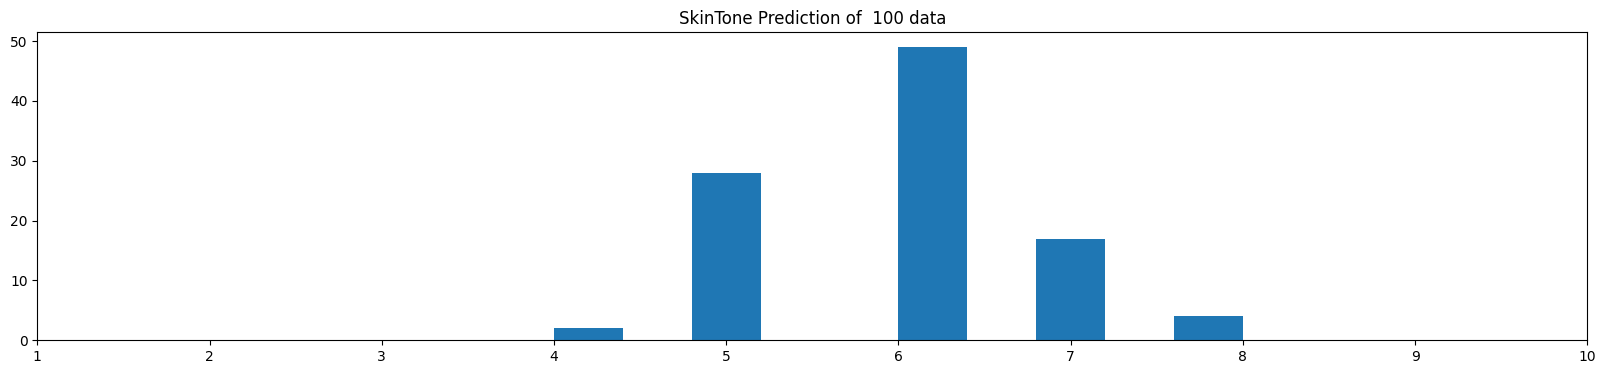

In [ ]:
path = './utkface/crop_part1'
images = [os.path.join(path, i) for i in os.listdir(path) if not os.path.isdir(i)]
target_size = (224,224,3)
random_viz(path, target_size)

# Supervised Learning

In [ ]:
def load_image(image_path, target_size):
    img = load_img(image_path, target_size = target_size)
    img_array = img_to_array(img)
    return img_array

def predict(path, model, target_size):
    img = load_image(path, target_size)
    img = tf.expand_dims(img,0)
    x = img/255
    prediction = model.predict(x, use_multiprocessing = True,
                               verbose = 0)
    prediction = np.argmax(prediction)

    return x, prediction

def viz_utils(path_list, model, target_size):
    n = len(path_list)
    fig, ax = plt.subplots(1, n, figsize = (n*4, 4))
    for i, image in enumerate(path_list):
        img, prediction = predict(image, model, target_size)
        ax[i].imshow(img[0])
        ax[i].set_title(f'Tone {prediction+1}')
    plt.show()

def predict_batch(path_list, model, target_size, num = 100):
  list_prediction = []

  images = random.sample(path_list, num)
  for image in images:
    list_prediction.append(predict(image, model, target_size)[1]+1)
  print('\n\n')
  plt.figure(figsize = (20,4))
  plt.hist(list_prediction)
  plt.title(f'SkinTone Prediction of  {num} data')
  plt.xticks(range(1, 11))
  plt.show()


def random_viz(path, model, target_size, num = 100):
    images = [os.path.join(path, i) for i in os.listdir(path) if not os.path.isdir(i)]
    image = random.sample(images, 5)
    viz_utils(image, model, target_size)
    predict_batch(images, model, target_size)

In [ ]:
path = './utkface/crop_part1'

## Model Diko (using Tf-Hub)

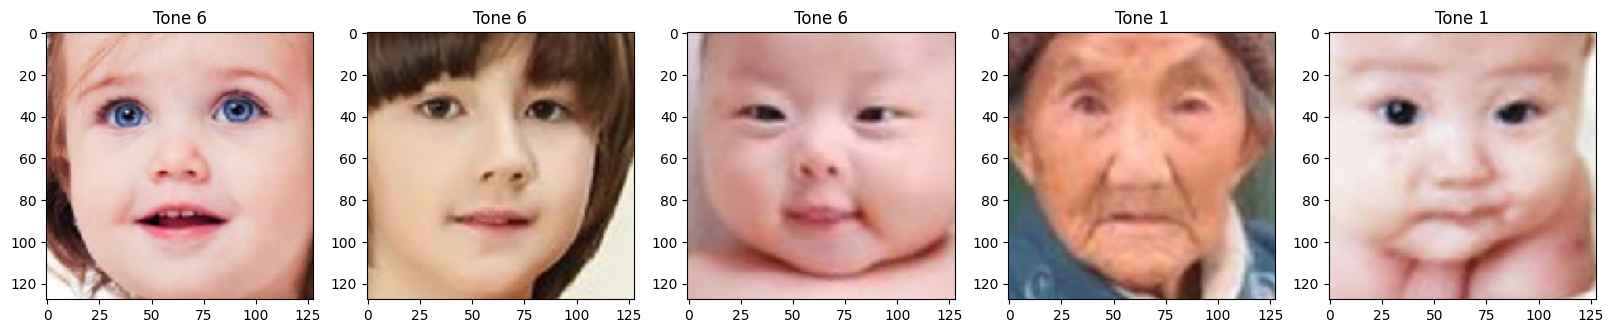

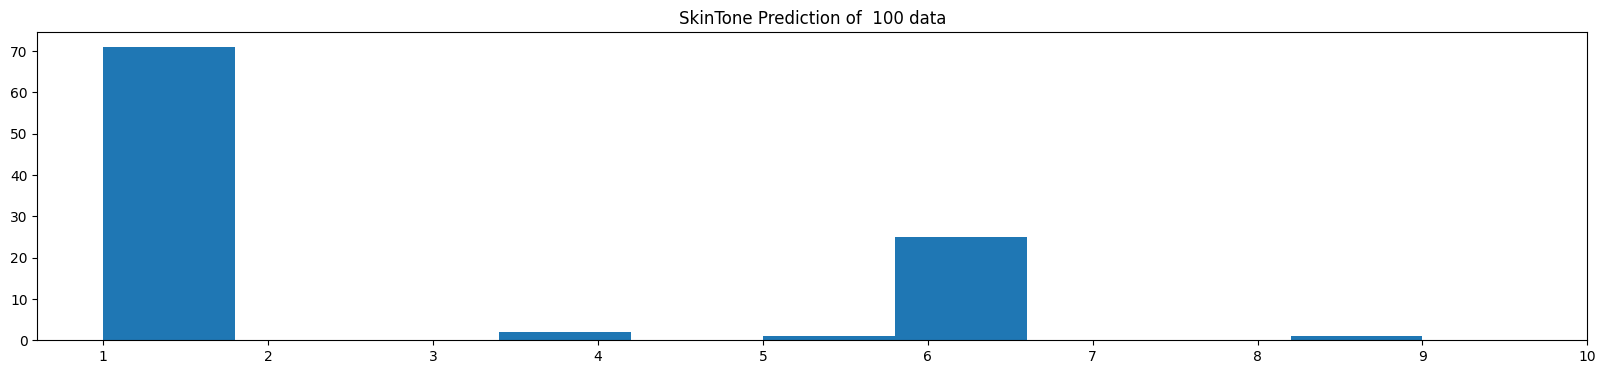

In [ ]:
model_diko = tf.keras.models.load_model(
  'model/skincolor_mobilev2.h5',
  custom_objects = {'KerasLayer': hub.KerasLayer})
target_size = (128,128,3)
random_viz(path, model_diko, target_size)

## Model Diko (Pre-cropped Dataset)

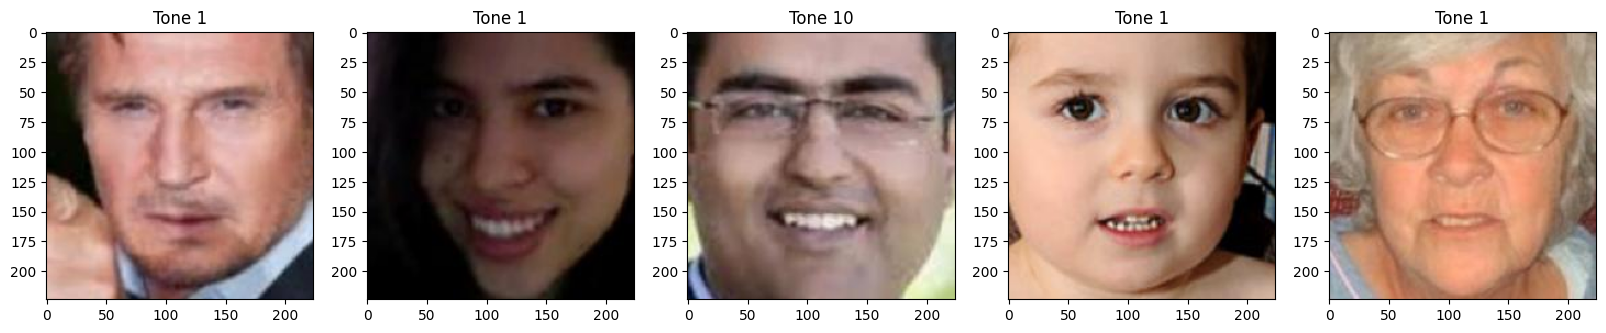

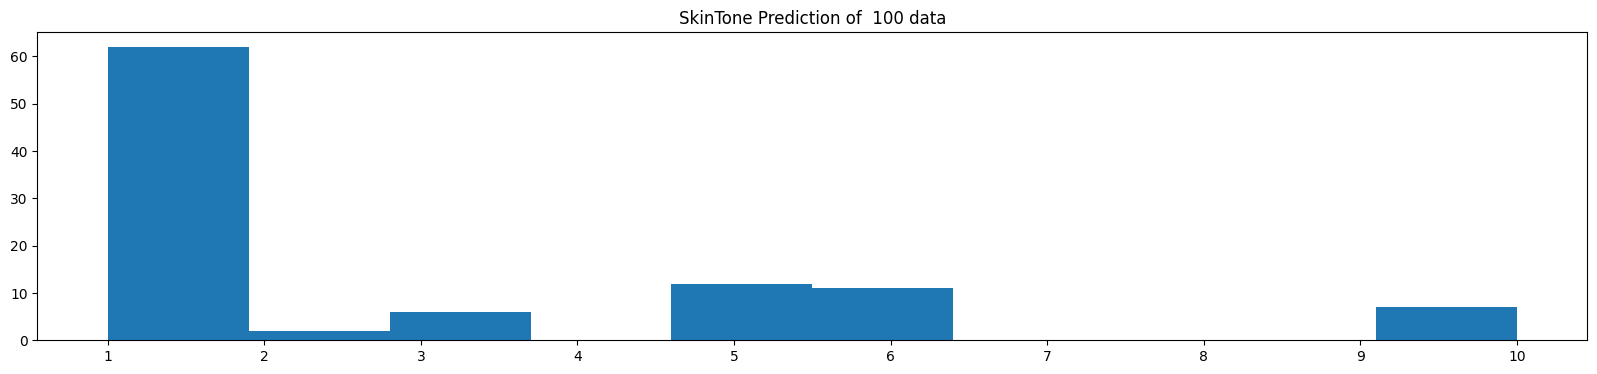

In [ ]:
model_diko = tf.keras.models.load_model(
  'model/mobilev2crop.h5')
target_size = (224,224,3)
random_viz(path, model_diko, target_size)

## Model Diko (MobileV3)

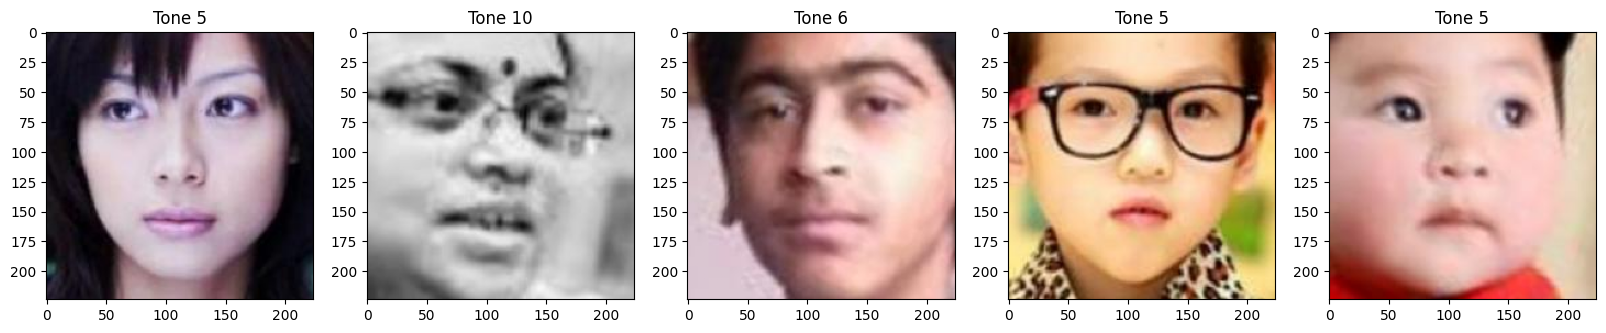

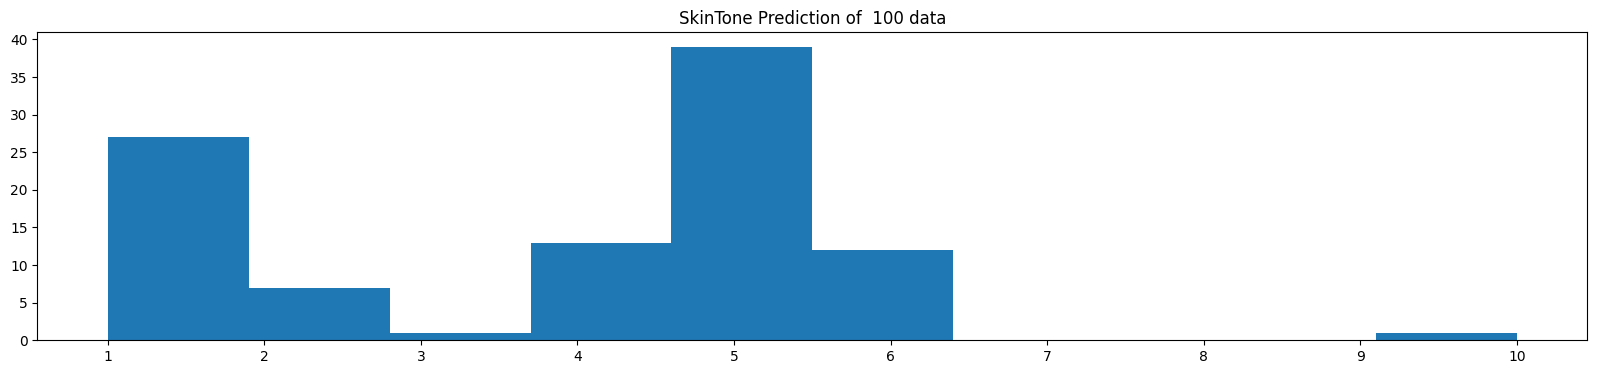

In [ ]:
model_diko = tf.keras.models.load_model(
  'model/mobilev3scrop.h5')
target_size = (224,224,3)
random_viz(path, model_diko, target_size)

## Model Dewa (MobileNet-512)

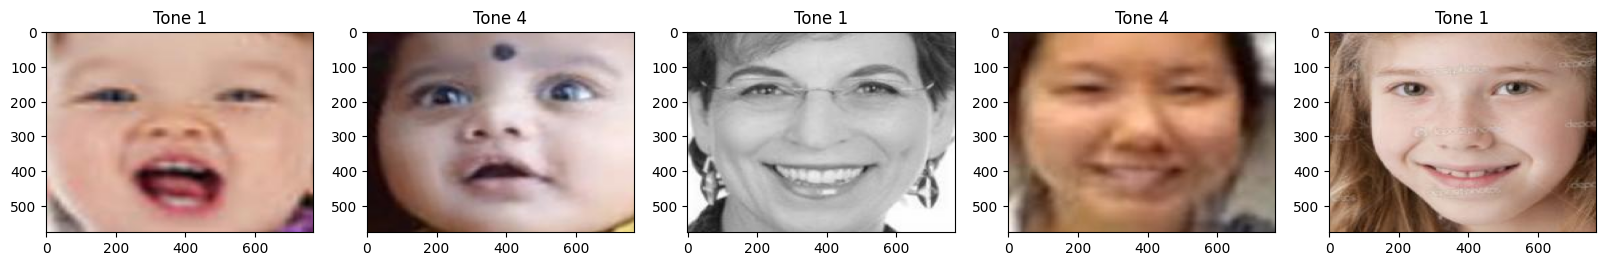

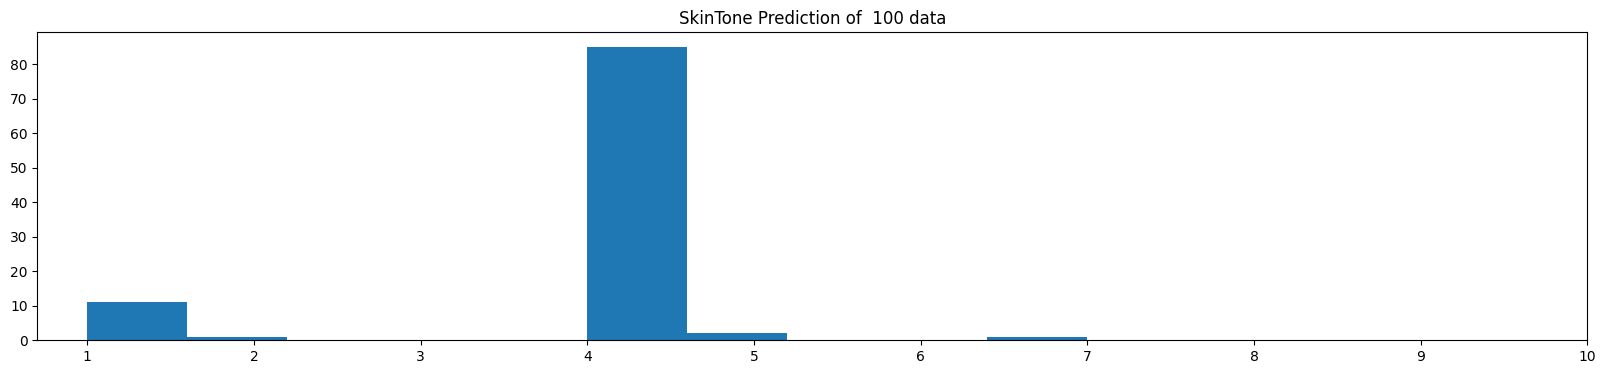

In [ ]:
model_dewa = tf.keras.models.load_model(
  'model/tone_model_mobilenet80-512unit.h5')
target_size = (576,768,3)
random_viz(path, model_dewa, target_size)

## Model Dewa (MobileNet80)

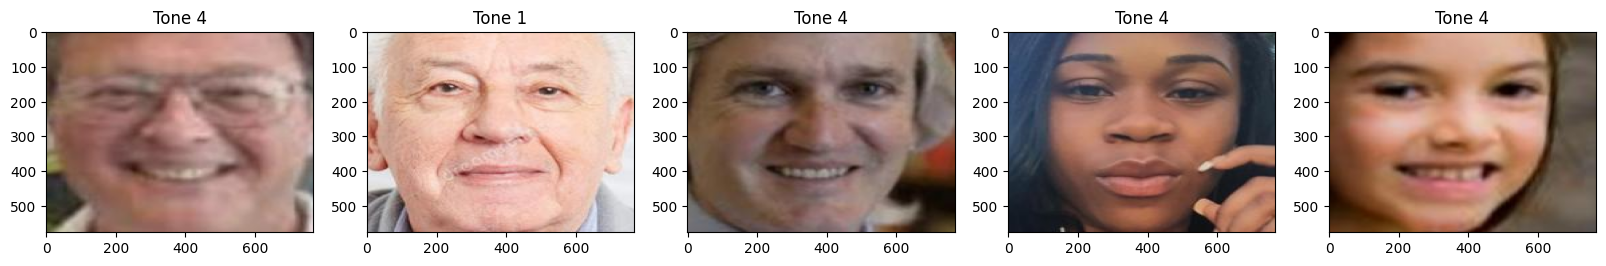

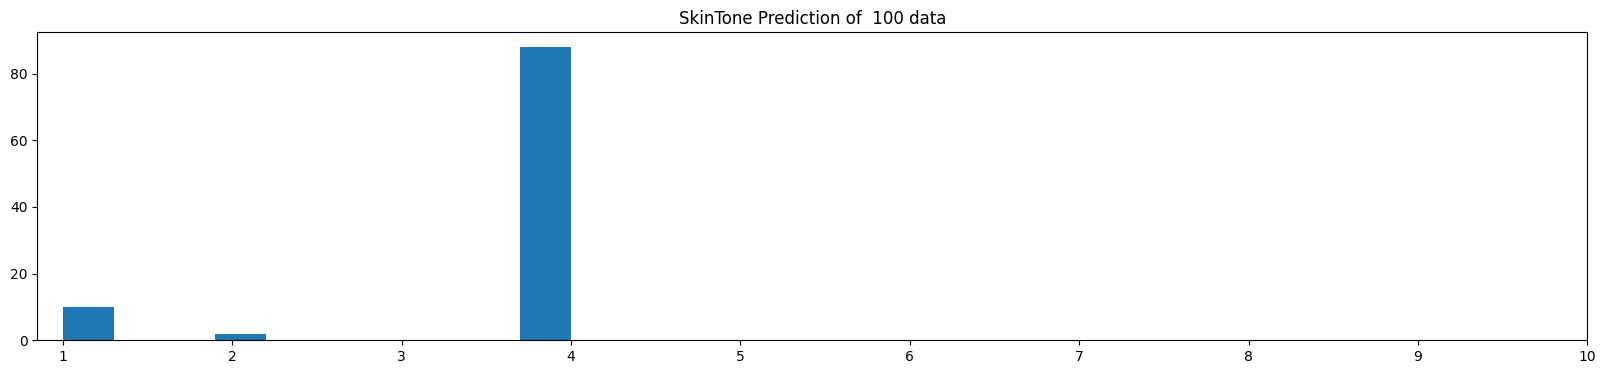

In [ ]:
model_dewa = tf.keras.models.load_model(
  'model/tone_model_mobilenet80.h5')
target_size = (576,768,3)
random_viz(path, model_dewa, target_size)